# Lab 5 Exercise - A little Linear Regression

## An initial attempt

In [1]:
!pip install torchbearer

     |████████████████████████████████| 143kB 179kB/s 


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchbearer
from torch import nn
from torch import optim
from torchbearer import Trial
import torchbearer.callbacks.tensor_board as tensorboard
from torchbearer.callbacks import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt

class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

Implement the following CNN model, and train it using Adam (default parameters) for 100 epochs (use
a GPU and be prepared to wait 6 or 7 minutes!). Use shuffled batches of 128 items. State the loss
function you’re using. Comment on the performance of the model.


Convolution2D , channels=48, size 3x3 , stride=1, padding=1
ReLU
Linear, 128 outputs
ReLU
Linear, 2 outputs

In [3]:
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(76800, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# build the model
model = SimpleCNN()

# PyTorch Loss Functions: https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
# define the loss function and the optimiser
loss_function = torch.nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
logger = CSVLogger('/content/log.csv', separator=',')
trial = Trial(model, optimiser, loss_function, metrics=['loss'], 
              callbacks=[logger]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
trial.run(epochs=100)
t = Trial(model, optimiser, loss_function, metrics=['loss']).to(device).with_test_generator(testloader)
t.evaluate(data_key=torchbearer.TEST_DATA)

{'test_loss': 15.671141624450684}

Final training loss:  1.6144911050796509
Final validation loss:  11.41973876953125


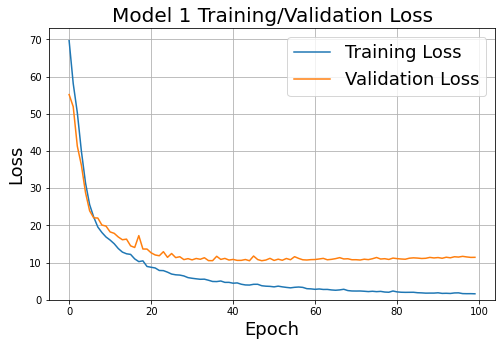

In [4]:
def train_val_plot(df, name):
    loss_plot = df['loss'].values
    val_loss_plot = df['val_loss'].values
    print("Final training loss: ", loss_plot[len(loss_plot)-1])
    print("Final validation loss: ", val_loss_plot[len(val_loss_plot)-1])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    #plt.tight_layout()
    ax.plot(loss_plot, label="Training Loss")
    ax.plot(val_loss_plot, label="Validation Loss")
    ax.legend(fontsize=18)
    ax.grid(True)
    ax.set_ylim(bottom=0)
    ax.set_title(name + " Training/Validation Loss", fontsize=20);
    ax.set_xlabel("Epoch", fontsize=18);
    ax.set_ylabel("Loss", fontsize=18);
    plt.savefig(name + "_Training.png", format='png', dpi=1200)
    plt.show()

df = pd.read_csv('/content/log.csv')
train_val_plot(df, name='Model 1')

## A second attempt


Implement the following CNN model, and train it using Adam (default parameters) for 100 epochs. Use shuffled batches of 128 items. Comment on the model performance.

Convolution2D, channels=48, size=3x3, stride=1, padding=1
ReLU
Convolution2D , channels=48, size=3x3, stride=1, padding=1
ReLU
Global Max Pool
Linear, 128 outputs
ReLU
Linear, 2 outputs


In [5]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        m = nn.AdaptiveMaxPool2d(output_size=(1,1))
        out = m(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# build the model
model2 = SimpleCNN2()

# PyTorch Loss Functions: https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

# define the loss function and the optimiser
loss_function = torch.nn.MSELoss()
optimiser = optim.Adam(model2.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
logger = CSVLogger('/content/log2.csv', separator=',')
trial = Trial(model2, optimiser, loss_function, metrics=['loss'], 
              callbacks=[logger]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
trial.run(epochs=100)
t = Trial(model2, optimiser, loss_function, metrics=['loss']).to(device).with_test_generator(testloader)
t.evaluate(data_key=torchbearer.TEST_DATA)

{'test_loss': 15.206214904785156}

Final training loss:  12.331724166870115
Final validation loss:  11.060550689697266


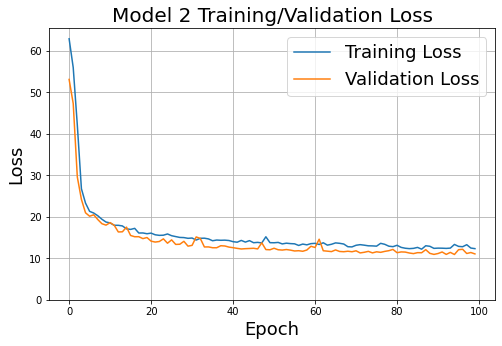

In [6]:
df = pd.read_csv('/content/log2.csv')
train_val_plot(df, name='Model 2')

## Something that actually works?

Modify the model from Section 2 as follows:
1. Modify the number of input channels to the first convolutional layer to be 3 instead of 1
2. In the forward pass, before the first convolution, modify the input, x, using the following code:

idxx = torch.repeatinterleave(torch.arange(−20,20,dtype=torch.float).unsqueeze(0)/40.0, repeats=40, dim=0).to(x.device)
idxy = idxx.clone().t()
idx = torch.stack([idxx,idxy]).unsqueeze(0)
idx = torch.repeatinterleave(idx, repeats=x.shape[0], dim=0)
x = torch.cat([x,idx], dim=1)

Train the modified model using Adam (default parameters) for 100 epochs. Use shuffled batches of 128 items. Comment on the model performance. Describe the rationale for the modification that was made.


In [7]:
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20,dtype=torch.float).unsqueeze(0)/40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx,idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x,idx], dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        m = nn.AdaptiveMaxPool2d(output_size=(1,1))
        out = m(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# build the model
model3 = SimpleCNN3()

# PyTorch Loss Functions: https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

# define the loss function and the optimiser
loss_function = torch.nn.MSELoss()
optimiser = optim.Adam(model3.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
logger = CSVLogger('/content/log3.csv', separator=',')
trial = Trial(model3, optimiser, loss_function, metrics=['loss'], 
              callbacks=[logger]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
trial.run(epochs=100)
t = Trial(model3, optimiser, loss_function, metrics=['loss']).to(device).with_test_generator(testloader)
t.evaluate(data_key=torchbearer.TEST_DATA)

{'test_loss': 1.1821495294570923}

Final training loss:  0.934127926826477
Final validation loss:  1.0229315757751465


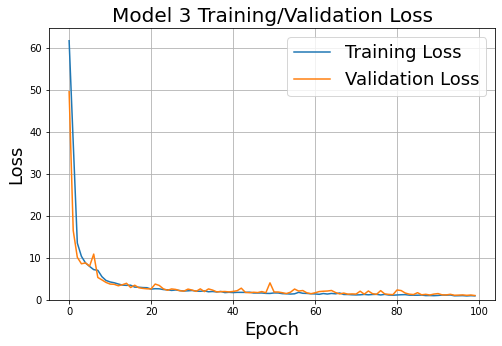

In [8]:
df = pd.read_csv('/content/log3.csv')
train_val_plot(df, name='Model 3')

In [9]:
t = Trial(model3, optimiser, loss_function, metrics=['loss']).to(device).with_test_generator(testloader)
test_predictions = t.predict(data_key=torchbearer.TEST_DATA)
print(test_predictions.shape)


torch.Size([500, 2])


Original Regression Parameters (dy/dx, c):  1.0 -17.0
Estimated Regression Parameters (dy/dx, c):  1.0416569 16.63763


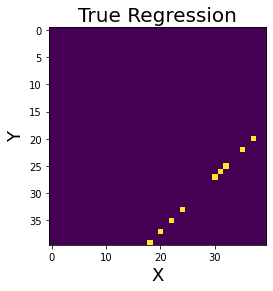

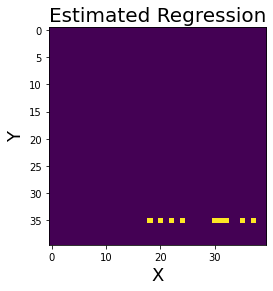

In [14]:
def pred_line(y_hat, y, index):
      dim = 40
      img = torch.zeros(dim, dim)
      xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
      dy_dx, c = y[index][1][0].cpu(), y[index][1][1].cpu()
      print("Original Regression Parameters (dy/dx, c): ", 
            dy_dx.numpy(), c.numpy())
      print("Estimated Regression Parameters (dy/dx, c): ",
            y_hat[0, 0].cpu().detach().numpy(), 
            y_hat[0, 1].cpu().detach().numpy())
      xy[:,1] = xy[:,0] * dy_dx + c
      xy.round_()
      xy = xy[ xy[:,1] > 0 ]
      xy = xy[ xy[:,1] < dim ]
      xy = xy[ xy[:,0] < dim ]

      for i in range(xy.shape[0]):
        x, y = xy[i][0], dim - xy[i][1]
        img[int(y), int(x)]=1
      if img.sum() > 2:
        img2 =  img.unsqueeze(0) 
        plt.imshow(img2[0, :, :])
        plt.title("True Regression", fontsize=20)
        plt.xlabel("X", fontsize=18)
        plt.ylabel("Y", fontsize=18)
        plt.savefig("True_Regression.png", format='png', dpi=1200)
        plt.show()
        img = torch.zeros(dim, dim)
        dy_dx, c = y_hat[index, 0].cpu(),y_hat[index, 1].cpu()
        xy[:,1] = xy[:,0] * dy_dx + c
        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < dim ]
        xy = xy[ xy[:,0] < dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          img2 =  img.unsqueeze(0)
          plt.imshow(img2[0, :, :])
          plt.title("Estimated Regression", fontsize=20)
          plt.xlabel("X", fontsize=18)
          plt.ylabel("Y", fontsize=18)
          plt.savefig("Estimated_Regression.png", format='png', dpi=1200)
          plt.show()

pred_line(test_predictions, list(testloader.dataset), 18)